Sampling Rate:  173.61 Hz
Spectral Bandwidth between: 0.5 Hz to 85 Hz
The application of a low-pass filter of 40 Hz, as described in the manuscript, is regarded as the first step of analysis

SET A	Z.zip <br>
SET B 	O.zip <br>
SET C	N.zip <br>
SET D	F.zip <br>
SET E	S.zip <br><br>
In the present study, EEGs from five patients were selected, all of whom had achieved complete seizure control after resection of one of the hippocampal formations, which was therefore correctly diagnosed to be the epileptogenic zone

# Project 3

The aim of the project is to build a classification model to analyze EEG data and classify it into different activities & also into seizure / non-seizure activity. the projects makes use of Bonn EEG data and two classification tasks are performed. The first task, Binary Classifiation aims at classifying records into seizure or non-seizure activity. The second task is Multi-Class Classification that aims to classify the records into five types: eye-open, eye-closed, hippocampal region, epileptogenic region, seizure. This task will futher help us in identify the EEG activity better.

In [1]:
import os
import mne
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from typing import Union
import matplotlib.pyplot as plt
from pyedflib import EdfReader
import seaborn as sns
import matplotlib.pyplot as plt
from pyrqa.time_series import TimeSeries 
from pyrqa.settings import Settings
from sklearn.utils import class_weight
from pyrqa.analysis_type import Classic
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from sklearn import preprocessing, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix


PROJECTDIR = Path(os.getcwd())
DATAPATH = os.path.join(PROJECTDIR.parent.absolute(), 'dataset-bonn')

### Data Preprocessing

We will be building a metadata dataframe that will make it easier to inspect the EEG files from different classes without loading the medical data into memory. Below is the mapping of different folders to their respective classnames

In [2]:
meta = {
    'Z': 'eye-open: seizure-free', 
    'O': 'eye-close: seizure-free', 
    'N': 'hippocampal region: seizure-free', 
    'F': 'epileptogenic region: seizure-free', 
    'S': 'seizure'
}

Let's also setup a label encoder and a label decoder. This is make it easiler to map match the predicited integers to the categorical labels.

In [3]:
label_encoder = {idx:fname  for idx, fname in enumerate(meta)}
label_encoder

{0: 'Z', 1: 'O', 2: 'N', 3: 'F', 4: 'S'}

In [4]:
def build_metadf(metainfo: dict, label_enc: dict, datadir: str = DATAPATH):
    eegsignal_dirs = [i for i in os.listdir(DATAPATH) if not i.startswith('.')]
    
    filenames = []
    filepaths = []
    labels = []
    folders = []
    labels_encoded = []
    rev_encoded = {v:k for k,v in label_enc.items()}
    
    for dr in eegsignal_dirs:
        folderpath = os.path.join(datadir, dr)
        fnames = [f for f in sorted(os.listdir(folderpath)) if f.endswith('txt')\
                  or f.endswith('TXT')]
        fpaths = [os.path.join(folderpath,f) for f in fnames]
        
        filenames.extend(fnames)
        filepaths.extend(fpaths)
        labels.extend([metainfo[dr]] * len(fnames))
        folders.extend([dr]*len(fnames))
        labels_encoded.extend([rev_encoded[dr]]*len(fnames))
        
    return pd.DataFrame({
        'folder': folders, 'filename': filenames, 
        'filepath': filepaths, 'label': labels,
        'label_encoded': labels_encoded
    })

In [5]:
metadf = build_metadf(meta, label_encoder)

In [6]:
metadf.head()

,folder,filename,filepath,label,label_encoded
0,N,N001.TXT,/Users/rahulnenavath/Documents/University-Work...,hippocampal region: seizure-free,2
1,N,N002.TXT,/Users/rahulnenavath/Documents/University-Work...,hippocampal region: seizure-free,2
2,N,N003.TXT,/Users/rahulnenavath/Documents/University-Work...,hippocampal region: seizure-free,2
3,N,N004.TXT,/Users/rahulnenavath/Documents/University-Work...,hippocampal region: seizure-free,2
4,N,N005.TXT,/Users/rahulnenavath/Documents/University-Work...,hippocampal region: seizure-free,2


We have 100 records from each class. This indicates that data is well balanced and there will be no majority class bias in the model training phase.

In [7]:
metadf['label_encoded'].value_counts()

label_encoded
2    100
0    100
4    100
3    100
1    100
Name: count, dtype: int64

### Visualisation

Loading one sample from each class to visualise the data and find some patterns unique to each class.

In [8]:
sample_data = {}

for folder in meta:
    fil = metadf['folder'] == folder
    record = metadf[fil]
    filepath = record['filepath'].values[0]
    filelabel = record['label'].values[0]
    sample_data[filelabel] = np.loadtxt(filepath)

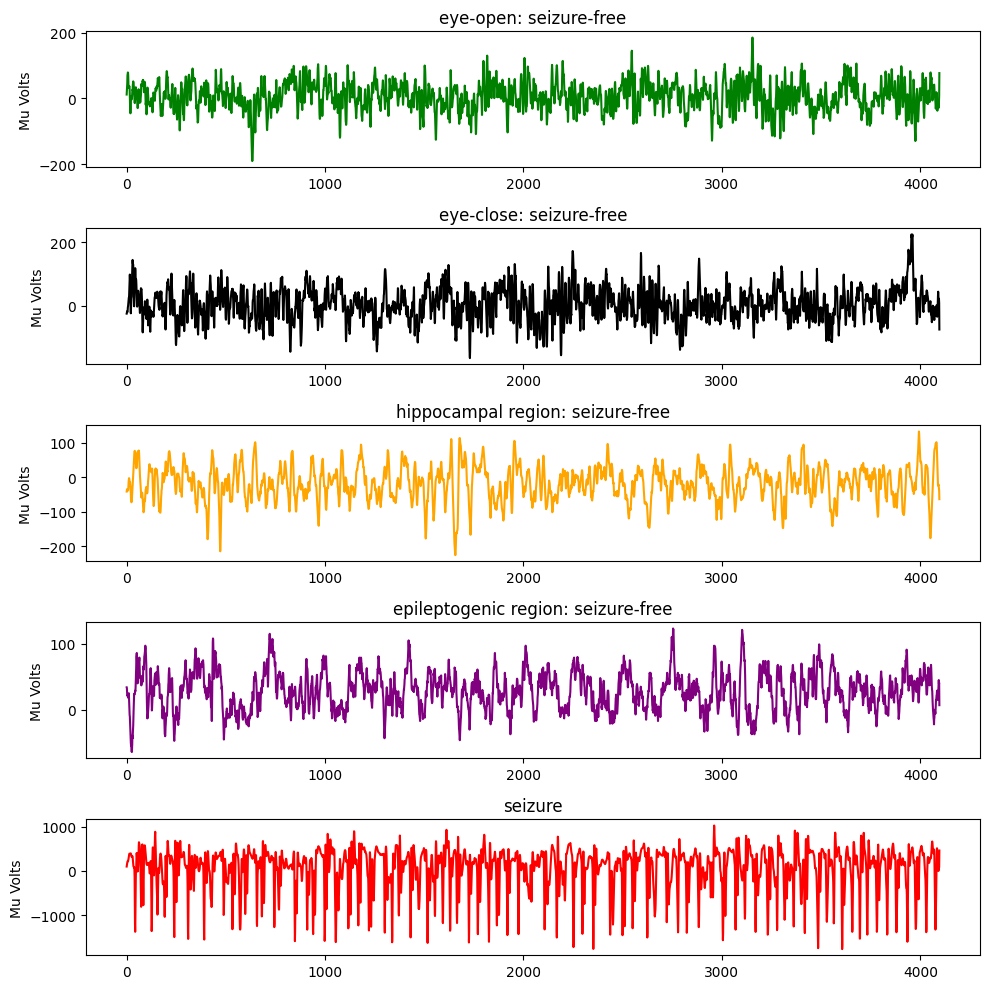

In [9]:
colors = ['green', 'black', 'orange', 'purple', 'red']
fig, axes = plt.subplots(len(sample_data), 1, figsize=(10,10))
for idx, (ax, (label, data)) in enumerate(zip(axes, sample_data.items())) :
    ax.plot(data, color=colors[idx])
    ax.set_title(label)
    ax.set_ylabel('Mu Volts')

plt.tight_layout()
plt.show()

In [10]:
x = np.loadtxt(metadf.iloc[0]['filepath'])
print(f'Each EEG recording in the dataset has the following shape:\
{x.reshape(1, -1).shape}')

Each EEG recording in the dataset has the following shape: (1, 4097)


<b>Observations:</b> An EEG recording from the dataset is a single channel, 4097 features, time-series data. The Amplitudes of surface EEG recordings are typically in the order of some mu Volts. For intracranial EEG recordings amplitudes range around some 100 mu Volts. For seizure activity these voltages can exceed 1000 mV. Inspecting the plot of recordings from each class we can identify that the seizure records are very distinct from other brain activity recordings. This is a good sign as it helps the model in great detail to learn the seizure characteristics. The eye-open & eye-close activity readings look visually similar to eachother. So there is a good chance this might confuse the model. The readings from the epileptogenic region are also distinctive from other activity / regions. Its crest and troughs are wider when compared to the other activity readings.

### Building Dataset

Reading the files from the local directory, using a memory-efficient python generator function, and storing the result in a Numpy Matrix

In [11]:
def build_dataset(metadata: pd.DataFrame, channels: int):
    
    def filepath_gen(data: pd.DataFrame):
        for _, rec in data.iterrows():
            yield rec['filepath'], rec['label_encoded']
    
    records = np.zeros((len(metadata), channels), dtype=np.float64)
    labels = []
    
    for idx, (filepath, label) in enumerate(filepath_gen(metadata)):
        eeg_reading = np.loadtxt(filepath)
        records[idx] = eeg_reading
        labels.append(label)
    
    print(f'Built Data Matrix of Shape: {records.shape}')
    return records, np.array(labels)

In [12]:
records, labels = build_dataset(metadf, channels=4097)

Built Data Matrix of Shape: (500, 4097)


Now let's try to take a sample record from the data matrix and plot the EEG recording for each class. This is to verify wether the data from the matrix looks similar to the above visualisation.

In [13]:
sample_locs = [np.argwhere(labels == label)[0][0] for label in range(5)]
sample_data = {meta[label_encoder[labels[idx]]]: records[idx] for idx in sample_locs}

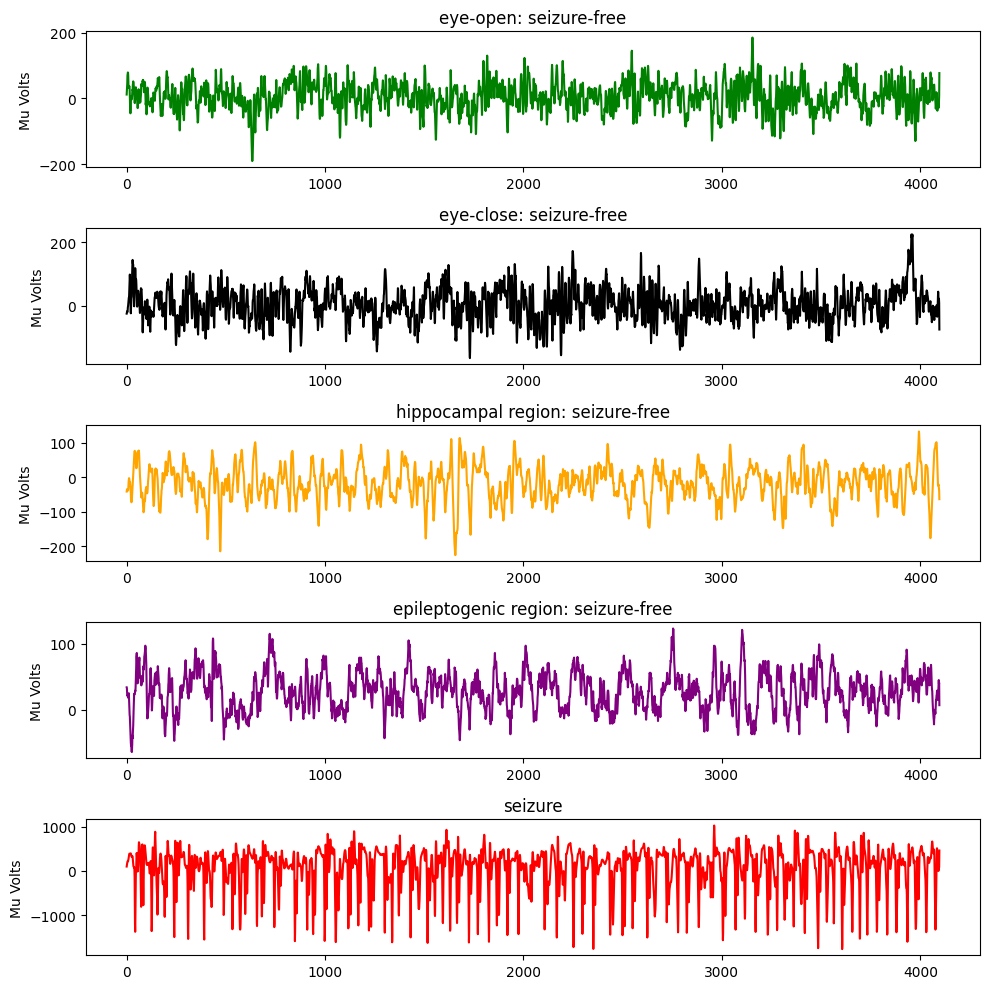

In [14]:
colors = ['green', 'black', 'orange', 'purple', 'red']
fig, axes = plt.subplots(len(sample_data), 1, figsize=(10,10))
for idx, (ax, (label, data)) in enumerate(zip(axes, sample_data.items())) :
    ax.plot(data, color=colors[idx])
    ax.set_title(label)
    ax.set_ylabel('Mu Volts')

plt.tight_layout()
plt.show()

The sample from the data matrix matches the earlier visualisation. We can proceed forward to next step!

### Feature Extraction
Here we make use of RQA analysis to find recurrance & determinism features from the time series data

In [15]:
def get_rqa_features(features: np.array):
    
    rec_rate, det_vals = [], []
    for i in range(len(features)):
        
        ts = TimeSeries(features[i], 
                        embedding_dimension=1,
                        time_delay=1)
        
        settings = Settings(ts,
                            neighbourhood=FixedRadius(0.5),
                            similarity_measure=EuclideanMetric,
                            theiler_corrector=1)
        
        computation = RQAComputation.create(settings,
                                            verbose=True)
        
        result = computation.run()
        rec_rate.append(result.recurrence_rate)
        det_vals.append(result.determinism)
    
    return np.array(rec_rate), np.array(det_vals)

In [16]:
%%capture
rec, det = get_rqa_features(records)
records = np.column_stack([records, rec, det])

## Binary Classification Task
As we observe from above, the label 4 is the seizure class. We only need to make a copy of this multi-activity labels and map label 4 as "1" for seizure records and rest as "0" for non-seizure class.

In [17]:
binary_labels = np.copy(labels)
binary_labels[binary_labels != 4] = 0
binary_labels[binary_labels == 4] = 1

In [18]:
non_seizure_idx = np.where(binary_labels == 0)[0][0]
seizure_idx = np.where(binary_labels == 1)[0][0]

non_seizure = records[non_seizure_idx]
seizure = records[seizure_idx]

Visualizing seizure & non-seizure readings

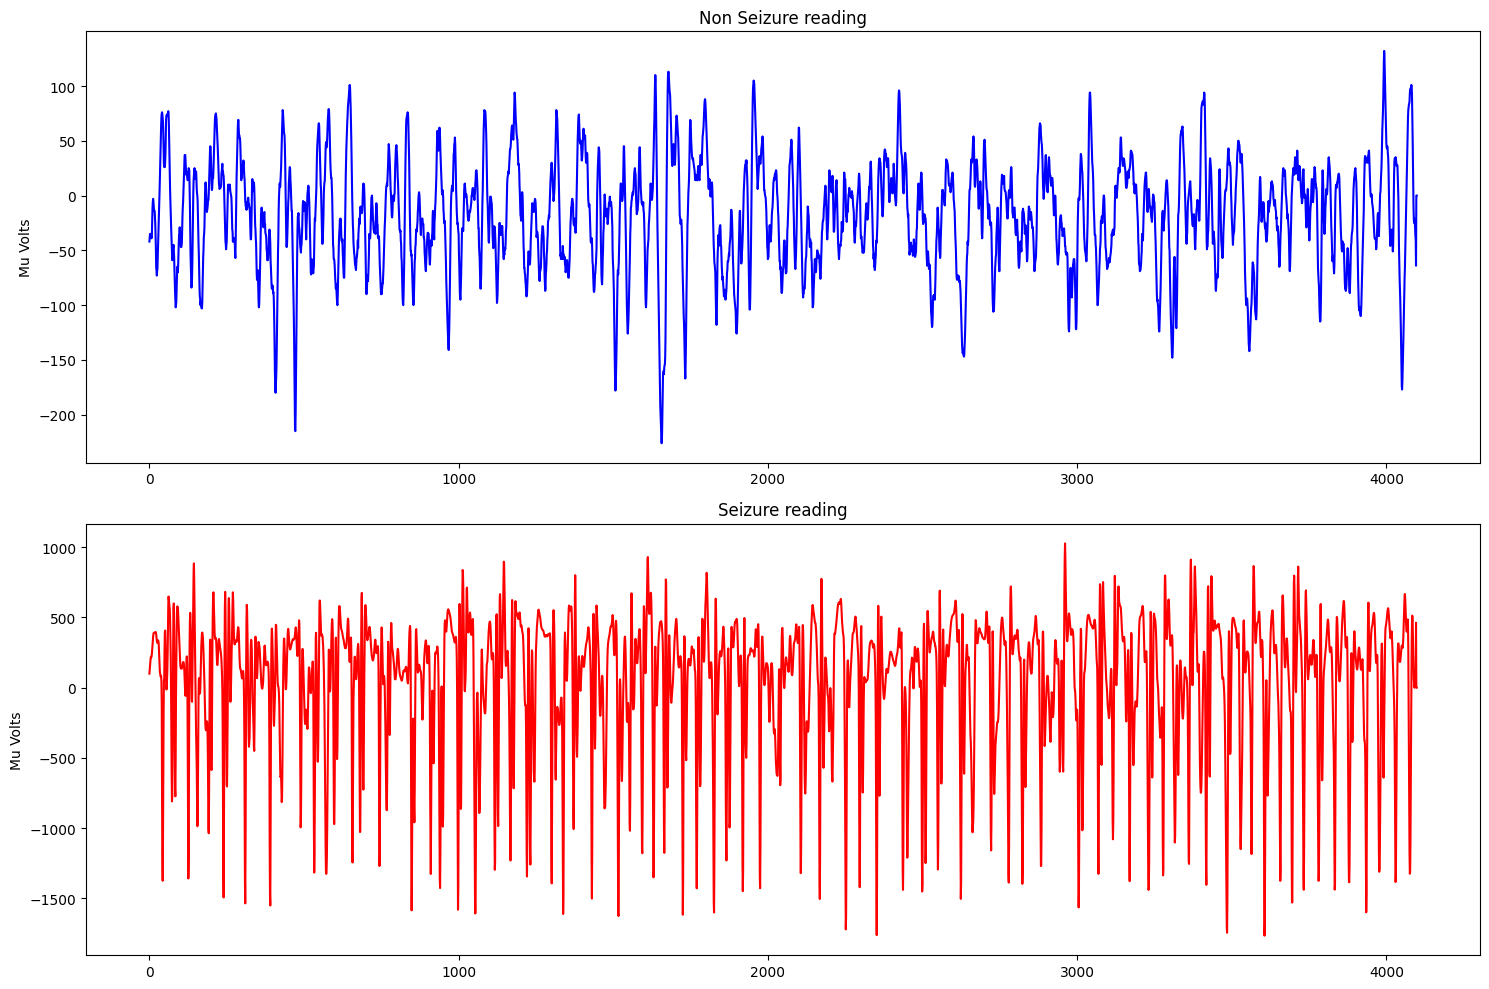

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].plot(non_seizure, color='blue')
axes[0].set_title('Non Seizure reading')
axes[0].set_ylabel('Mu Volts')

axes[1].plot(seizure, color='red')
axes[1].set_title('Seizure reading')
axes[1].set_ylabel('Mu Volts')

plt.tight_layout()
plt.show()

Clearly the Mu volts's value range for seizure & non-seizure readings are very distintive. The distance between each crest & trough for Seizure reacords is very small. Whereas its not the same case for Non-Seizure reading. <br><br>Now's lets look whether the data is balanced or not

In [20]:
pd.Series(binary_labels).value_counts()

0    400
1    100
Name: count, dtype: int64

There is a clear data imbalance present. This can be mitigated by penalising the majority class and boosting the minority class using a weighting scheme while training the models.

### Data Splitting

The dataset will be split into train & test sets by 80-20 ratio. Stratify sampling is employed here to sample records that are representative of each class.

In [21]:
test_perc = 0.2
X_train, X_test, y_train, y_test = \
model_selection.train_test_split(records,binary_labels,\
                                 test_size=test_perc,stratify=binary_labels)

In [22]:
print(f'Train samples: {len(X_train)}\nTest samples: {len(X_test)}')

Train samples: 400
Test samples: 100


In [23]:
pd.Series(y_train).value_counts()

0    320
1     80
Name: count, dtype: int64

### Standardization
We employ standard scaling and bring the mean to 0 and standard deviation to 1 for every feature column. This is essential because each feature's range of values will be very different and will only make it harder for the model to find associations across features.

In [24]:
scalar = preprocessing.StandardScaler()
scalar.fit(X_train)
X_train_std = scalar.transform(X_train)
X_test_std = scalar.transform(X_test)

### Model Training

Here four models will be trained on the binary classification task and to mitigate the class imbalance problem, all the scikit learn models will have a parameter called `class_weight` set to `balanced`. This will ensure the majority class will be penalised and minority class be boosted. In regards to the XGBoot classifier, we have to pass a scale ratio of sample weight. To understand the penality faced by the majority & minority class, the class weights are computed and later the scale ratio is computed.

In [25]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [26]:
for c in [0, 1]:
    idx = np.where(y_train==c)[0][0]
    print(f'Class: {y_train[idx]} | Weight: {classes_weights[idx]}')

Class: 0 | Weight: 0.625
Class: 1 | Weight: 2.5


In [27]:
yt = pd.Series(y_train)
scale_ratio = float(yt.value_counts()[0]) / yt.value_counts()[1]
print(f'POS Scale Ratio: {scale_ratio}')

POS Scale Ratio: 4.0


For the Majority class, class 0 (non-seizure records), the weight is 0.625 and for the Minority class, class 1 (seizure records), it is 2.5. With a weightage of 2.5 to the minority class we are instructing the model to pay more focus on this class.

In [28]:
binary_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    'XGBoost': XGBClassifier(scale_pos_weight=scale_ratio),
}

10 Fold Cross Validation is employed to find the higher accurate & unbiased model. F1 score is selected as a performance metric.

In [29]:
kf = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [30]:
def cross_val_score_mean_f1(model_instance, 
                            features:np.array, 
                            label:np.array, 
                            kf: model_selection.StratifiedKFold):
    f1_scores = []
    for train_index, test_index in kf.split(features, label):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = label[train_index], label[test_index]
        model_instance.fit(X_train, y_train)
            
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

    mean_f1 = np.mean(f1_scores)
    return mean_f1

In [31]:
results = {}
for model_name, model in binary_models.items():
    mean_f1 = cross_val_score_mean_f1(model, X_train_std, y_train, kf)
    results[model_name] = mean_f1
    print(f'{model_name} Mean F1 Score: {mean_f1}')

Logistic Regression Mean F1 Score: 0.8309721739183213
Random Forest Mean F1 Score: 0.9217696272121205
Decision Tree Mean F1 Score: 0.9336329695334481
XGBoost Mean F1 Score: 0.9427195774918735


XG-Boost shows a 95% F1 score and performs the best compared to rest of the models in binary classification task on 10 Fold Cross-Validation.

### Evaluation

In [32]:
y_pred = binary_models['XGBoost'].predict(X_test_std)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        80
           1       0.83      1.00      0.91        20

    accuracy                           0.96       100
   macro avg       0.92      0.97      0.94       100
weighted avg       0.97      0.96      0.96       100



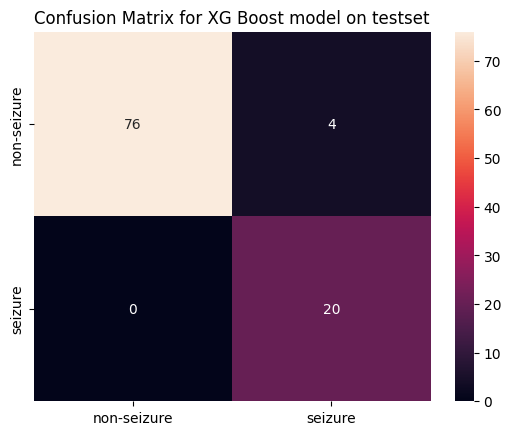

In [33]:
labs = ['non-seizure', 'seizure']
sns.heatmap(confusion_matrix(y_test, y_pred), ann
            

## Multi-Class Classification Task

We will be using the initial multi-activity labels and build classification models to perform multi-class classification task

### Data Splitting
The dataset will be split into train & test sets by 80-20 ratio. Stratify sampling is employed here to sample records that are representative of each class.

In [34]:
test_perc = 0.2
X_train, X_test, y_train, y_test = \
model_selection.train_test_split(records,labels,test_size=test_perc,stratify=labels)

In [35]:
print(f'Train samples: {len(X_train)}\nTest samples: {len(X_test)}')

Train samples: 400
Test samples: 100


All the classes in the train dataset are well balanced. Hence we don't have to compute the class weights and handle data imbalance.

In [36]:
pd.Series(y_train).value_counts()

1    80
3    80
0    80
2    80
4    80
Name: count, dtype: int64

### Standardization
A standardization scheme similar to prior binary classification task is done here.

In [37]:
scalar = preprocessing.StandardScaler()
scalar.fit(X_train)
X_train_std = scalar.transform(X_train)
X_test_std = scalar.transform(X_test)

### Model Training 
As we have five total classes, we will be performing multi-class classification and training the models on a 10 fold cross validation process to find the best model. Similar to prior binary classification task, F1 score is selected as a performance metric.

In [38]:
multi_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'XGBoost': XGBClassifier(),
}

In [39]:
kf = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [40]:
results = {}
for model_name, model in multi_models.items():
    mean_f1 = cross_val_score_mean_f1(model, X_train_std, y_train, kf)
    results[model_name] = mean_f1
    print(f'{model_name} Mean F1 Score: {mean_f1}')

Logistic Regression Mean F1 Score: 0.4962664462816166
Random Forest Mean F1 Score: 0.7103372958311038
Decision Tree Mean F1 Score: 0.5874624354347735
XGBoost Mean F1 Score: 0.7395965776569492


XG-Boost shows a 74% F1 score and performs the best compared to rest of the models in multi-class classification task on 10 Fold Cross-Validation.

### Evaluation

In [42]:
y_pred = multi_models['XGBoost'].predict(X_test_std)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.80      0.74        20
           1       0.58      0.70      0.64        20
           2       0.82      0.70      0.76        20
           3       0.84      0.80      0.82        20
           4       1.00      0.85      0.92        20

    accuracy                           0.77       100
   macro avg       0.79      0.77      0.78       100
weighted avg       0.79      0.77      0.78       100



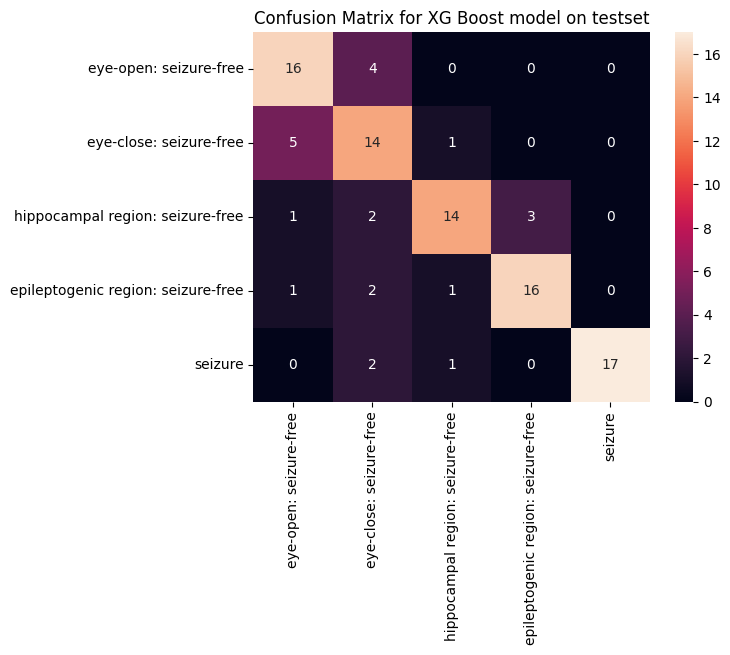

In [43]:
labs = [meta[f] for l, f in label_encoder.items()]
sns.heatmap(confusion_matrix(y_test, y_pred), \
            annot=True, xticklabels=labs, yticklabels=labs)
plt.title(f'Confusion Matrix for XG Boost model on testset')
plt.show()